# 2.2 간단한 Retrieval 에이전트 (feat. PDF 전처리 꿀팁)

- RAG 에이전트를 만들어봅니다
- [zerox](https://zerox.ai/)를 통해 PDF 파일을 전처리하는 방법을 알아봅니다


## 환경설정

- RAG 파이프라인을 위해 필요한 패키지들을 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [32]:
%pip install -qU pypdf langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


- `PyPDFLoader`를 사용해 전처리된 데이터를 확인합니다

In [33]:
from langchain_community.document_loaders import PyPDFLoader

pdf_file_path = './income_tax.pdf'
loader = PyPDFLoader(pdf_file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

ValueError: File path ./income_tax.pdf is not a valid file or url

In [ ]:
pages[35]

Document(metadata={'producer': 'iText 2.1.7 by 1T3XT', 'creator': 'PyPDF', 'creationdate': '2025-01-10T10:55:01+09:00', 'moddate': '2025-01-10T10:55:01+09:00', 'source': './income_tax.pdf', 'total_pages': 133, 'page': 35, 'page_label': '36'}, page_content='법제처                                                            36                                                       국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 “퇴직소득 산출세액”이라 한다\n)으로 한다.<개정 2013. 1. 1., 2014. 12. 23.>\n1. 해당 과세기간의 퇴직소득과세표준에 제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n \n           제2관 세액공제 <개정 2009. 12. 31.>\n \n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합\n산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 더한 금액에 해당하는\n금액을 종합소득 산출세액에서 공제한다. <개정 2009. 12. 31.>\n② 제1항에 따른 공제를 “배당세액공제”라 한다.<개정 2009. 12. 31.>\n③ 삭제<2003. 12. 30.>\n④ 제1항을 적용할 때 배당세액공제의 대상이 되는 배당소득금액은 제14조제2항의 종합소득과세표준에 포함된 배\n당소득금액으로서 이자소득등의 종합과세기준금액을 초과하는 것

- 데이터 전처리를 위한 [py-zerox](https://www.piwheels.org/project/py-zerox/) 패키지를 설치합니다

In [ ]:
%pip install -q py-zerox

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

- 노트북에서 `asyncio`를 사용하기 위해 `nest_asyncio`를 설치합니다

In [ ]:
%pip install -q nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nest_asyncio
nest_asyncio.apply()

- `py-zerox`를 통해 pdf파일을 전처리합니다
- 강의에서는 `OpenAI`를 사용하지만, 아래 예제는 `AzureOpenAI`를 사용합니다

In [ ]:
from pyzerox import zerox
import os
import json
import asyncio

### 모델 설정 (Vision 모델만 사용) 참고: https://docs.litellm.ai/docs/providers ###

## 일부 모델에 필요할 수 있는 추가 모델 kwargs의 자리 표시자
kwargs = {}

## Vision 모델에 사용할 시스템 프롬프트
custom_system_prompt = None

model = "gpt-4o-mini" ## openai vision model - supports vision and is available
# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# 메인 비동기 진입점을 정의합니다
async def main():
    file_path = "./income_tax.pdf" ## 로컬 파일 경로 및 파일 URL 지원

    ## 일부 페이지 또는 전체 페이지를 처리
    select_pages = None ## 전체는 None, 특정 페이지는 int 또는 list(int) 페이지 번호 (1부터 시작)

    output_dir = "./documents" ## 통합된 마크다운 파일을 저장할 디렉토리
    result = await zerox(file_path=file_path, model=model, output_dir=output_dir,
                        custom_system_prompt=custom_system_prompt, select_pages=select_pages, **kwargs)
    return result


# 메인 함수를 실행합니다:
result = asyncio.run(main())

# 마크다운 결과를 출력합니다
print(result)

ERROR:root:Error converting PDF to images: Unable to get page count. Is poppler installed and in PATH?


TypeError: 'NoneType' object is not iterable

- zerox를 활용한 전처리 후 생성된 마크다운 파일을 LangGraph에서 활용하기 위해 [unstructured](https://unstructured.io/) 패키지를 설치합니다
- `UnstructuredMarkdownLoader`를 사용해 전처리된 데이터를 확인합니다
    - `loader`활용 시 테이블 구조가 사라지는 것을 확인할 수 있습니다

In [34]:
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.


In [35]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

In [36]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_path = "./documents/income_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)

In [37]:
document_list[43]

Document(metadata={'source': './documents/income_tax.md'}, page_content='간접투자자에게 지급자에 해당하여 제6조제1항 및 제57조제1항 제1호에 따른 국외법인에 해당하는 개인으로서 간접투자사업이 발생하는 것을 제외하는 구조로 투자적으로 보낼 것 다른 자본사업으로 납부할 것은 규정의 범위에 따라 외국법인에서의 경우 해당 세액을 포함하며, 이하 제1항에서 ‘간접투자외국세액’이라 한다.\n\n제1항을 적용할 때 거주자가 간접투자회사를 통해 지급받은 소득과 종합소득세법에 의해 공제되는 금액은 다음과 같이 한다.\n\n간접투자회사로부터 지급받은 소득: ‘자본시장과 금융투자업에 관한 법률’ 제23조제6항에 따른 기초자산(간접투자와의별임이나 대체가격)을 말하며, 이하 이 조 및 제29조제1항에서 “세액기준가격”이라 한다)기준으로 계산된 금액. 단, 증권시장에서 상장된 간접투자회사의 중립에 따라 간접투자회사의 지급받은 소득은 대통형별로 판단하여 계산한 금액으로 한다.\n\n종합소득산출세액에서 공제하는 금액: 간접투자국법인에서 세후기준가격을 고려하여 대통형별로 정하는 범위에 따라 계산한 금액\n\n제3항에 따라 종합소득산출세액에서 공제할 수 있는 금액은 다음 금액과 이하 함을 “공제한도금액”이라 한다. 이 경우 제1항제2호의 금액에 해당 하는 금액은 다음 과세기간은 개시일부터 10년 이내에 거쳐있는 과세기간으로 이힐여 그의 이월된 과세기간의 공제한도금액 내에 공제할 수 있다.\n\n공제한도금액 = A\n\n      B\n\nA: 제65조에 따라 계산한 당해 과세기간의 종합소득산출세액 B: 간접투자회사로부터 지급받은 소득(상기금액에 대해 간접투자국법인)\n\n제1항부터 제3항까지의 규정에 따른 간접투자회사 등으로부터 지급받은 소득의 계산방법, 그 밖에 세액공제에 필요한 사항은 대통령령으로 정한다. [본조신설 2022. 1. 31.] [시행일: 2022. 1. 1.] 제57조의2\n\n제58조(자산손실세액의귀증) 1. 사

- 마크다운 테이블을 활용하기 위해 `.md` -> `.txt`로 변환합니다

In [38]:
%pip install -q markdown html2text beautifulsoup4

367.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [39]:
import markdown
from bs4 import BeautifulSoup

text_path = './documents/income_tax.txt'

# 마크다운 파일을 읽어옵니다
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환합니다
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장합니다
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


- `TextLoader`를 사용해 전처리된 데이터를 확인합니다

In [40]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [41]:
document_list[39]

Document(metadata={'source': './documents/income_tax.txt'}, page_content='제46조(재산 등기에 대한 소득금액의 계수 특칙)\n① 가족주택 제216조제1항제1호․제2호 및 제66조에 해당하는 채권 또는 증권자 단위에 의하여 담당론 그리고 No. 30에서 “채권”이라 하는 방법이온으로부터 해당 채권에서 발생하는 바는 동일한 경우라 할지라도 할 것입니다.(하여도) 제133조2 및 제156조2하고 제33조2와 “이자대”라 하는 바는 기준개인사업자의 주식집 관리․관사와 주식평범 재산의 보유 관리 및 신주로는기예치하는 일반의 법적 근거로 의하게 된다. 이를 특히 문서이상의 규명 과 같은 방법 및 제59조제이통제조문 제63조에 해당하는 채권의 주식으로 전환․상환되는 경우를 포함한다. 이하 간이자료가 해당 경우를 매끈(일 년의 질도 혹은 보님과 비례를 포망하여, 판매조사정과 하이클래스 조정에 대해 대응)한다.\n소득세법\n령역으로 정하는 경우는 제한한다. 이하 제133조2의1에 해당하는 경우에는 거주자에게 그 본유?관별로 귀속되는 이자소득 상응액을 해거주자의 제16조의2로 보아 소득입액을 계산한다. <개정> 2010. 12. 27, 2012. 1. 1, 2020. 12. 29>\n① 제1항을 적용할 때 해당 거주자가 해당 채권을 보유한 기간을 대륙청령으로 정하는 바에 따라 임직원을 못 하는 경우에는 제133조2의1제1항에 의한 원천징수기간의 이자 상당액에 해당 거주자에게 귀속되는 것으로 보아 소득입액을 계산한다. <개정> 2010. 12. 27.\n② 제1항 및 제2항에 따른 이자 상응액의 계산방법과 그 밖에 필요한 사항은 대륙청령으로 정한다.\n[전문개정 2009. 12. 31.]\n제46조(중도 해지로 인한 이자소득금의 계산상 특징)\n거주자의 제16조제1항, 제2호, 제3호 및 제6조에 해당하는 채권 또는 중고 및 하위 단계의 양도가 가능한 증권으로서 대륙청령을 정하는 바에 의한 아, 제133조2의1 및 제15

- 전처리된 데이터를 벡터화하기 위해 [Chroma](https://docs.trychroma.com/getting-started)를 활용합니다
- LangChain과의 호환을 위해 [langchain-chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/)를 설치합니다

In [42]:
%pip install -q langchain-chroma

377.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [43]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [44]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

In [45]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [46]:
query = '연봉 5천만원 직장인의 소득세는?'

In [47]:
retriever.invoke(query)

[Document(id='0b3d724d-1048-4713-877a-9b3178256978', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
 Document(id='1dac7462-2ebd-4d73-9bb2-ad35da85dcc1', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)

- `state`를 선언하고 에이전트를 생성합니다
- 2.1강에서 진행한 것과 다르게 `messages` 커스텀 변수들을 선언합니다
    - `query`는 사용자의 질문을 저장하는 용도로 사용합니다
    - `context`는 벡터 스토어에서 추출한 데이터를 저장하는 용도로 사용합니다
    - `answer`는 최종 응답을 저장하는 용도로 사용합니다

In [48]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [49]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

- `retrieve` 노드는 사용자의 질문을 받아 벡터 스토어에서 추출한 데이터를 반환합니다

In [51]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

- `LangChain`의 `hub`를 통해 미리 정의된 RAG 프롬프트를 활용합니다
    - `hub`에는 이미 검증된 프롬프트들이 많기 때문에 프로젝트 진행 시 좋은 시작점이 됩니다
    - `hub`에서 프롬프트를 찾아보고, 동작을 확인한 후 커스텀 하는 것을 권장합니다

In [52]:
from langchain import hub
from langchain_openai import ChatOpenAI
prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model='gpt-4o')

In [53]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state['context']  # state에서 검색된 문서를 추출합니다.
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    rag_chain = prompt | llm  # RAG 프롬프트와 LLM을 연결하여 체인을 만듭니다.
    response = rag_chain.invoke({'question': query, 'context': context})  # 질문과 문맥을 사용하여 응답을 생성합니다.
    return {'answer': response}  # 생성된 응답을 포함한 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [54]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [55]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [56]:
graph = graph_builder.compile()

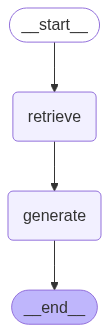

In [57]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- 병렬처리나 `conditional_edge`가 없는 경우 `add_sequence()`를 통해 순차적으로 동작하는 그래프를 생성할 수 있습니다

In [58]:
sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])

In [59]:
sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

In [60]:
sequence_graph = sequence_graph_builder.compile()

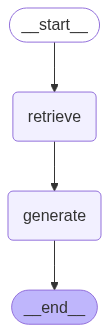

In [61]:
display(Image(sequence_graph.get_graph().draw_mermaid_png()))

In [62]:
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '연봉 5천만원 직장인의 소득세는?',
 'context': [Document(id='0b3d724d-1048-4713-877a-9b3178256978', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='1dac7462-2ebd-4d73-9bb2-ad35da85dcc1', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납